BUSINESS QUESTIONS
1.	Which products/content are most frequently interacted with by users?
2.	Which user segments have similar purchase/viewing behaviors?
3.	What products/content have high engagement but low recommendation exposure?
4.	How do seasonal trends affect product/content interactions?

Top 10 Most Frequently Interacted Items:


,itemid,interaction_count
0,187946,1349
1,461686,1170
2,5411,921
3,370653,735
4,219512,730
5,298009,666
6,257040,666
7,309778,652
8,96924,620
9,384302,619


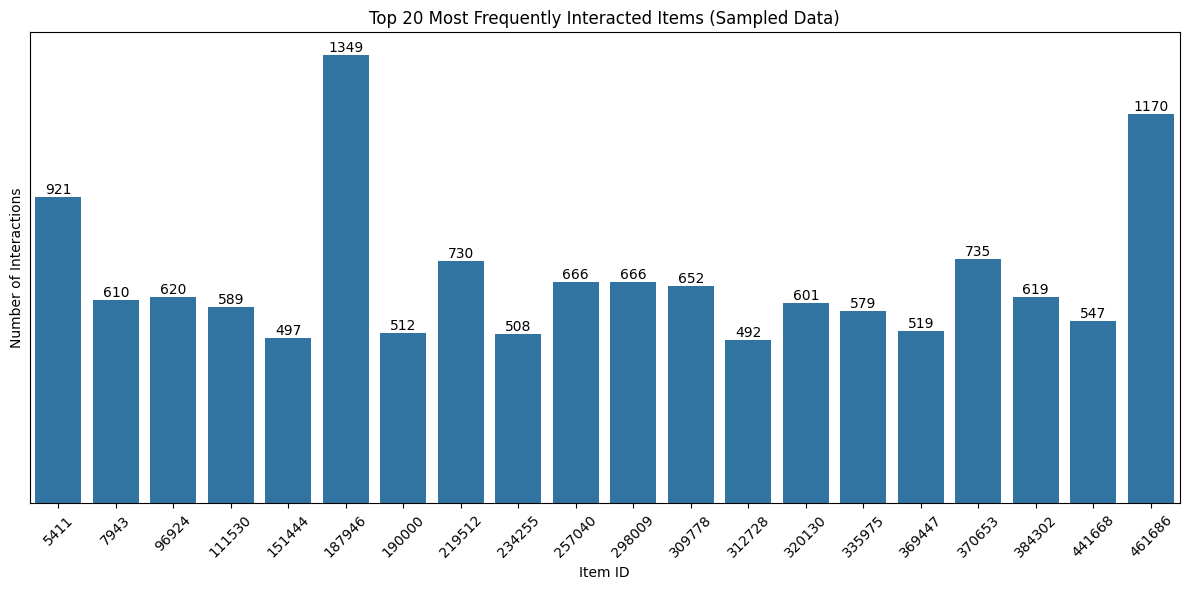

In [ ]:
# which products/content are most frequently interacted with by users?

item_interactions = events_df_sampled['itemid'].value_counts().reset_index()
item_interactions.columns = ['itemid', 'interaction_count']

# Display the top 10 most frequently interacted items
print("Top 10 Most Frequently Interacted Items:")
display(item_interactions.head(10))

# Visualize the top 20 most frequently interacted items
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='itemid', y='interaction_count', data=item_interactions.head(20))
plt.title('Top 20 Most Frequently Interacted Items (Sampled Data)')
plt.xlabel('Item ID')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
ax.set_yticks([]) # Remove y-tick marks and labels

# Add data labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f') # Format as rounded integers

plt.tight_layout()
plt.show()

## User Segmentation

### Subtask:
Analyze user behavior (purchase and viewing history) to identify user segments with similar patterns.

**Reasoning**:
Cluster users based on their interaction features (`num_events`, `unique_events`, `time_spent`, etc.) using K-Means clustering to identify user segments.

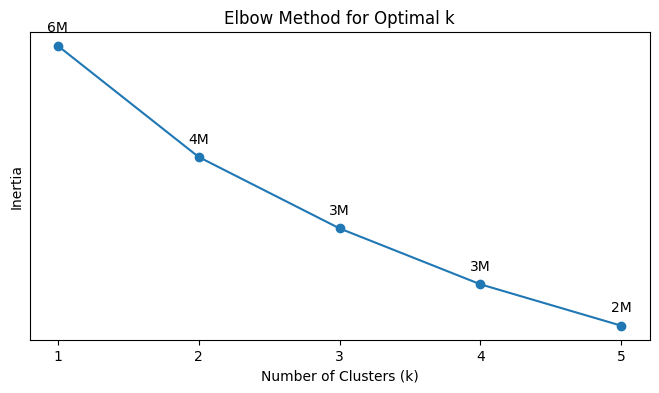


First few rows of user_features with cluster labels:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label,cluster_label
0,0,2,1,-170.152,-85.076000,0.00,2,0,0,1,0
1,2,3,1,-1430.585,-476.861667,213.47,2,0,0,1,0
2,3,1,1,0.000,0.000000,0.00,1,0,0,1,0
3,6,1,1,0.000,0.000000,0.00,1,0,0,1,0
4,7,1,1,0.000,0.000000,0.00,1,0,0,1,0



Cluster Analysis:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label
cluster_label,,,,,,,,,,
0,704353.396349,1.446414,1.023582,-3.852188e+04,-1.530801e+04,3.714856e+04,1.258599,0.030719,0.008636,0.86747
1,611169.076923,845.384615,2.923077,-4.107265e+05,-4.852375e+02,3.853309e+06,576.807692,66.538462,53.307692,-1.00000
2,705275.883775,8.948518,1.160166,3.452356e+06,1.354823e+06,5.320261e+06,6.540562,0.390146,0.185517,-1.00000


In [ ]:
#Which user segments have similar purchase/viewing behaviors?

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select features for clustering from the user_features DataFrame
user_features_for_model = user_features[['num_events', 'unique_events', 'time_spent',
                                         'avg_time_between_events', 'max_time_between_events',
                                         'num_items_viewed', 'num_adds_to_cart', 'num_transactions']].copy()

# Handle potential infinite values which can arise from time difference calculations
user_features_for_model.replace([float('inf'), float('-inf')], float('nan'), inplace=True)

# Fill remaining missing values with 0 or a suitable imputation strategy
# For simplicity, we will fill with 0. Consider other strategies if appropriate.
user_features_for_model.fillna(0, inplace=True)


# Standardize the features
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features_for_model)

# Determine the optimal number of clusters using the elbow method (optional but recommended)
# This can be computationally intensive, so we'll limit the range of k
inertia = []
k_range = range(1, 6) # Limiting to a small range for demonstration

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(user_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(8, 4))
ax = plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.yticks([]) # Remove y-tick marks and labels

# Add data labels to each point with formatted values
for i, txt in enumerate(inertia):
    if txt >= 1_000_000:
        label = f'{txt/1_000_000:.0f}M'
    elif txt >= 1_000:
        label = f'{txt/1_000:.0f}K'
    else:
        label = f'{txt:.0f}'
    plt.annotate(label, (k_range[i], inertia[i]), textcoords="offset points", xytext=(0,10), ha='center')


plt.show()

# Based on the elbow method (or a predefined number), choose the number of clusters
# Let's assume we choose 3 clusters for demonstration purposes.
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
user_features['cluster_label'] = kmeans.fit_predict(user_features_scaled)

# Display the first few rows with cluster labels
print("\nFirst few rows of user_features with cluster labels:")
display(user_features.head())

# Analyze the characteristics of each cluster
print("\nCluster Analysis:")
display(user_features.groupby('cluster_label').mean())

Based on the cluster analysis, we identified three segments:

**Cluster 0**: Less engaged users with low interaction counts.

**Cluster 1**: Highly engaged users with significantly higher interaction and purchase frequency.

**Cluster 2**: Moderately engaged users with interaction levels between Cluster 0 and Cluster 1.

## Identify High Engagement Items

### Subtask:
Identify products/content that have high engagement based on user interactions.

**Reasoning**:
Analyze the `events_df_sampled` DataFrame to count the occurrences of 'view', 'addtocart', and 'transaction' events for each item to determine engagement levels.

In [ ]:
# What products/content have high engagement but low recommendation exposure?

# Calculate engagement metrics for each item using the sampled data
item_engagement = events_df_sampled.groupby('itemid')['event'].value_counts().unstack(fill_value=0)

# Rename columns for clarity
item_engagement.columns = [f'num_{event}_events' for event in item_engagement.columns]

# Calculate total interactions for each item
item_engagement['total_interactions'] = item_engagement.sum(axis=1)

# Display the first few rows of the item engagement DataFrame
print("First few rows of item_engagement:")
display(item_engagement.head())

# Identify items with high total engagement (e.g., top 100)
high_engagement_items = item_engagement.sort_values(by='total_interactions', ascending=False)

print("\nTop 10 High Engagement Items:")
display(high_engagement_items.head(10))

# We can also look at items with high engagement for specific event types, e.g., 'addtocart'
print("\nTop 10 Items with High Add-to-Cart Engagement:")
display(item_engagement.sort_values(by='num_addtocart_events', ascending=False).head(10))

First few rows of item_engagement:


,num_addtocart_events,num_transaction_events,num_view_events,total_interactions
itemid,,,,
4,0,0,1,1
6,0,0,16,16
15,0,0,4,4
16,0,0,5,5
17,0,0,1,1



Top 10 High Engagement Items:


,num_addtocart_events,num_transaction_events,num_view_events,total_interactions
itemid,,,,
187946,2,0,1347,1349
461686,129,44,997,1170
5411,2,0,919,921
370653,0,0,735,735
219512,21,5,704,730
298009,0,0,666,666
257040,37,11,618,666
309778,20,7,625,652
96924,0,0,620,620



Top 10 Items with High Add-to-Cart Engagement:


,num_addtocart_events,num_transaction_events,num_view_events,total_interactions
itemid,,,,
461686,129,44,997,1170
409804,64,16,274,354
312728,63,24,405,492
320130,55,13,533,601
29196,49,6,351,406
7943,40,20,550,610
48030,39,17,390,446
316753,37,7,300,344
369447,37,13,469,519


## Analyze Seasonal and Hourly Trends

### Subtask:
Analyze the timestamps in the `events` data to identify seasonal and hourly patterns in user interactions.

**Reasoning**:
Extract hour of day, day of week, and month from the timestamps in the `events_df_sampled` DataFrame and visualize the distribution of events across these time periods.

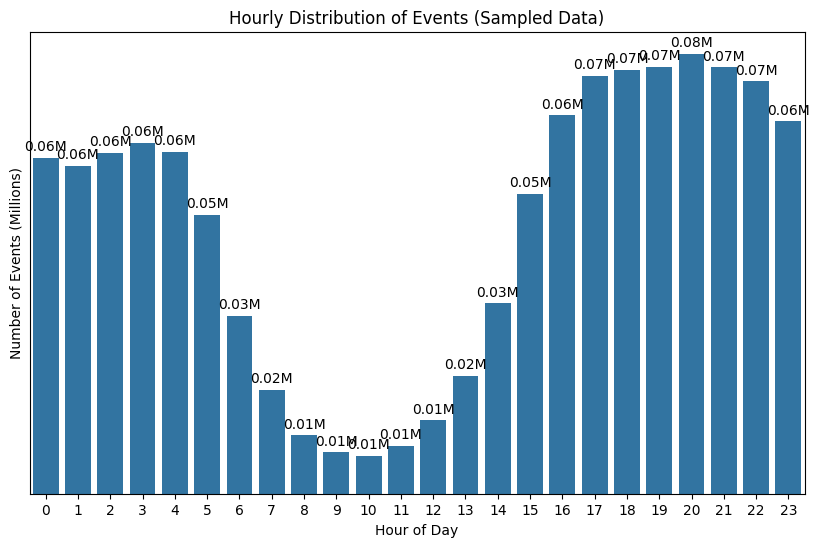

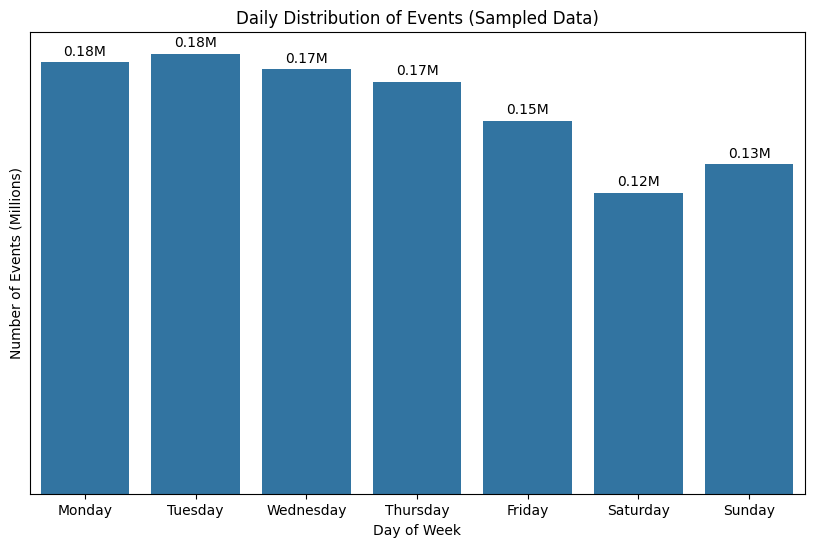

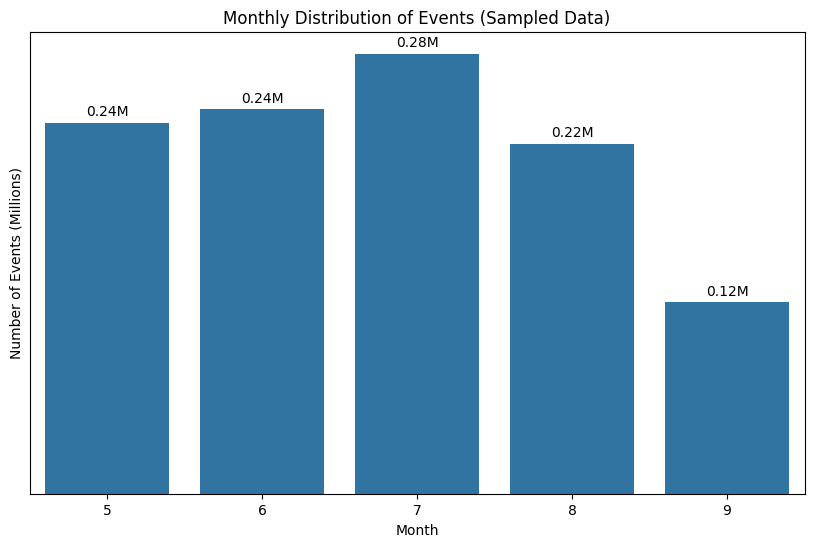

In [ ]:
# How do seasonal trends affect product/content interactions?

# Extract time-based features from the timestamp (using the sampled data)
events_df_sampled['hour'] = events_df_sampled['timestamp'].dt.hour
events_df_sampled['dayofweek'] = events_df_sampled['timestamp'].dt.dayofweek # Monday=0, Sunday=6
events_df_sampled['month'] = events_df_sampled['timestamp'].dt.month

# Analyze hourly trends
hourly_trends = events_df_sampled['hour'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
ax_hourly = sns.barplot(x=hourly_trends.index, y=hourly_trends.values / 1_000_000) # Convert to millions
plt.title('Hourly Distribution of Events (Sampled Data)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events (Millions)') # Update y-axis label
ax_hourly.set_yticks([]) # Remove y-tick marks and labels
for container in ax_hourly.containers:
    ax_hourly.bar_label(container, fmt='%.2fM', padding=3) # Format as .2fM
plt.show()

# Analyze daily trends (day of the week)
daily_trends = events_df_sampled['dayofweek'].value_counts().sort_index()
# Map dayofweek to names for better readability
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 6))
ax_daily = sns.barplot(x=[day_names[i] for i in daily_trends.index], y=daily_trends.values / 1_000_000) # Convert to millions
plt.title('Daily Distribution of Events (Sampled Data)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Events (Millions)') # Update y-axis label
ax_daily.set_yticks([]) # Remove y-tick marks and labels
for container in ax_daily.containers:
    ax_daily.bar_label(container, fmt='%.2fM', padding=3) # Format as .2fM
plt.show()

# Analyze monthly trends
monthly_trends = events_df_sampled['month'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
ax_monthly = sns.barplot(x=monthly_trends.index, y=monthly_trends.values / 1_000_000) # Convert to millions
plt.title('Monthly Distribution of Events (Sampled Data)')
plt.xlabel('Month')
plt.ylabel('Number of Events (Millions)') # Update y-axis label
ax_monthly.set_yticks([]) # Remove y-tick marks and labels
for container in ax_monthly.containers:
    ax_monthly.bar_label(container, fmt='%.2fM', padding=3) # Format as .2fM
plt.show()